<a href="https://colab.research.google.com/github/ujjwalbaid0408/DL/blob/master/Copy_of_keras_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STTP on Advances in Signal and Image processing - 29th May, 3.30-5.30 PM
# MNIST handwritten digits classification with CNNs


**Notebook Edited by: Ujjwal Baid (Research Scholar, SGGSIE&T, Nanded)**

In this notebook, we'll train a convolutional neural network (CNN, ConvNet) to classify MNIST digits using Keras (with either Theano or Tensorflow as the compute backend).  Keras version $\ge$ 2 is required. 

First, the needed imports. There are a few new layers compared to the Conventional-MLP notebook: Flatten, MaxPooling2D, Conv2D.




In [36]:
# Output displayed inline within frontends like the 
# Jupyter notebook, directly below the code

%matplotlib inline  


# Import libraries required throughout the script


# define model as sequential 
# (other is the Model class used with the functional API)

from keras.models import Sequential 

# import layers to build the model

from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D 
from keras.utils import np_utils

# backend, version, numpy, matplotlib(plot figure and graphs)

from keras import backend as K

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt

# Seaborn is a library for making statistical graphics in Python. 
#It is built on top of matplotlib and closely integrated with pandas 
# data structures.

import seaborn as sns
sns.set()

# Print Keras Version and backend

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.2.4 backend: tensorflow


Let's load the MNIST or Fashion-MNIST dataset.

In [37]:
# Load MNIST dataset from keras repository
# MNIST, MNIST fashion, CIFAR10 etc. available

from keras.datasets import mnist, fashion_mnist

# Divide into training and test dataset
# X:image, y: label

(X_train, y_train), (X_test, y_test) = mnist.load_data()
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Specify Number of classes in dataset
nb_classes = 10

# Convert to float 32 fomat
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalise the data with highest intensity
X_train /= 255
X_test /= 255

# one-hot encoding:
# Convert class vectors to binary class matrices
# np_utils is to convert 2 as [0 0 1 0 0 0 0 0 0 0]

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
Y_train: (60000, 10)


We'll have to do a bit of tensor manipulations, depending on the used backend (Theano or Tensorflow).

In [38]:
# input image dimensions as per tensorflow
# tensorflow format: (no of images, row, col, dimension)

img_rows, img_cols = 28, 28

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    print ('I am in theano')
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    print ('I am in tensorflw')

print ('Dimentions after reordering the data')    
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

I am in tensorflw
Dimentions after reordering the data
X_train: (60000, 28, 28, 1)
X_test: (10000, 28, 28, 1)


## Initialization

Now we are ready to create a convolutional model.

 * The `Convolution2D` layers operate on 2D matrices so we input the digit images directly to the model.  
 * The `MaxPooling2D` layer reduces the spatial dimensions, that is, makes the image smaller.
 * The `Flatten` layer flattens the 2D matrices into vectors, so we can then switch to  `Dense` layers as in the MLP model. 

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

In [39]:
# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

model = Sequential()

model.add(Conv2D(nb_filters, kernel_size,
                 padding='valid',
                 input_shape=input_shape,
                 activation='relu'))
model.add(Conv2D(nb_filters, kernel_size,
                 activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

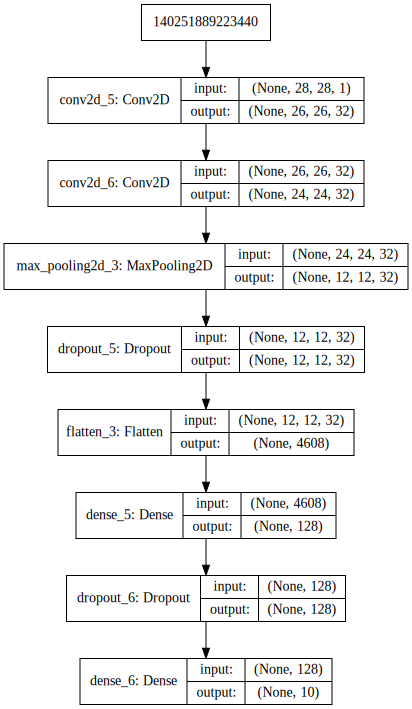

In [40]:
# Display Model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Learning

Now let's train the CNN model. Note that we do not need the `reshape()` function as in the MLP case. 

This is a relatively complex model, so training is considerably slower than with MLPs. 

In [42]:
%%time

epochs = 10 # one epoch takes about 45 seconds

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=2)

Epoch 1/10
 - 6s - loss: 0.0446 - acc: 0.9881
Epoch 2/10
 - 5s - loss: 0.0443 - acc: 0.9875
Epoch 3/10
 - 5s - loss: 0.0447 - acc: 0.9877
Epoch 4/10
 - 5s - loss: 0.0466 - acc: 0.9880
Epoch 5/10
 - 6s - loss: 0.0479 - acc: 0.9873
Epoch 6/10
 - 6s - loss: 0.0452 - acc: 0.9876
Epoch 7/10
 - 6s - loss: 0.0467 - acc: 0.9877
Epoch 8/10
 - 6s - loss: 0.0478 - acc: 0.9877
Epoch 9/10
 - 5s - loss: 0.0436 - acc: 0.9879
Epoch 10/10
 - 6s - loss: 0.0461 - acc: 0.9874
CPU times: user 49.5 s, sys: 11.7 s, total: 1min 1s
Wall time: 56 s


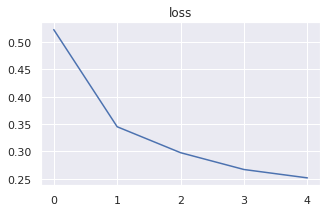

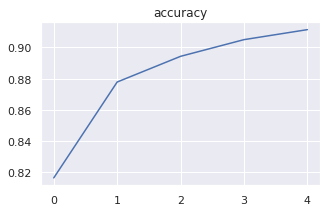

In [17]:
# Plot Loss

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# Plot Accuracy

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

## Inference

With enough training epochs, the test accuracy should exceed 99%.  

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html).  Even more results can be found [here](http://yann.lecun.com/exdb/mnist/). 

In [43]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 99.04%
CPU times: user 1.06 s, sys: 110 ms, total: 1.17 s
Wall time: 928 ms


We can again take a closer look on the results. Let's begin by defining
a helper function to show the failure cases of our classifier. 

In [0]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=10):
    rounded = np.argmax(predictions, axis=1)
    errors = rounded!=y_test
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(X_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and predictions[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            if K.image_dim_ordering() == 'th':
                plt.imshow(X_test[i,0,:,:], cmap="gray")
            else:
                plt.imshow(X_test[i,:,:,0], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], y_test[i]))
            ii = ii + 1

Here are the first 10 test digits the CNN classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


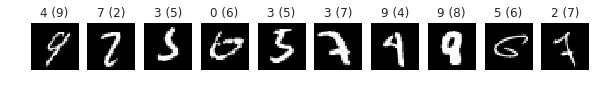

In [45]:
predictions = model.predict(X_test)

show_failures(predictions)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "6":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


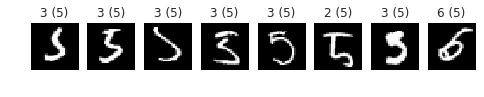

In [47]:
show_failures(predictions, trueclass=6)

---
*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-mnist-cnn.ipynb).*

## ***This is new***